In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import pickle
import matplotlib.pyplot as plt

In [2]:
batch_size = 100

# MNIST Dataset
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.5], std=[0.5])])

train_dataset = dsets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = dsets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
idx = train_dataset.targets == 1
train_dataset.targets = train_dataset.targets[idx]
train_dataset.data = train_dataset.data[idx]

idx = test_dataset.targets == 1
test_dataset.targets = test_dataset.targets[idx]
test_dataset.data = test_dataset.data[idx]


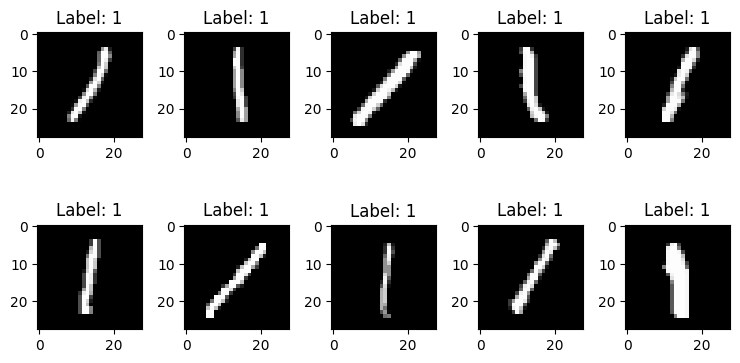

In [4]:
import matplotlib.pyplot as plt

num_row = 2
num_col = 5
num = num_row * num_col
X, Y = next(iter(train_loader))

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(num):
	ax = axes[i // num_col, i % num_col]
	ax.imshow(X[i, 0, :, :], cmap='gray')
	ax.set_title('Label: {}'.format(Y[i]))
plt.tight_layout()
plt.show()


In [5]:
class Generator(nn.Module):
	def __init__(self, input_size, output_size):
		super(Generator, self).__init__()
		self.fc1 = nn.Linear(input_size, 256)
		self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features * 2)
		self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features * 2)
		self.fc4 = nn.Linear(self.fc3.out_features, output_size)
		self.RReLU = nn.LeakyReLU(negative_slope=0.2)
		self.tanh = nn.Tanh()

	# forward method
	def forward(self, x):
		out = self.fc1(x)
		out = self.RReLU(out)

		out = self.fc2(out)
		out = self.RReLU(out)
		out = self.fc3(out)
		out = self.RReLU(out)
		out = self.fc4(out)
		out = self.tanh(out)
		return out


class Discriminator(nn.Module):
	def __init__(self, input_size):
		super(Discriminator, self).__init__()
		self.fc1 = nn.Linear(input_size, 1024)
		self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features // 2)
		self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features // 2)
		self.fc4 = nn.Linear(self.fc3.out_features, 1)
		self.RReLU = nn.LeakyReLU(negative_slope=0.2)
		self.sigmoid = nn.Sigmoid()
		self.dropout = nn.Dropout(p=0.3)

	# forward method
	def forward(self, x):
		out = self.fc1(x)
		out = self.RReLU(out)
		out = self.dropout(out)

		out = self.fc2(out)
		out = self.RReLU(out)
		out = self.dropout(out)

		out = self.fc3(out)
		out = self.RReLU(out)
		out = self.dropout(out)

		out = self.fc4(out)
		out = self.sigmoid(out)
		return out


In [6]:
z_dim = 100
mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)
G = Generator(input_size=z_dim, output_size=mnist_dim)
D = Discriminator(input_size=mnist_dim)

# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr)


In [ ]:
def D_train(x):
	#=======================Train the discriminator=======================#
	D.zero_grad()

	# train discriminator on real
	x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)

	D_output = D(x_real)
	D_real_loss = criterion(D_output, y_real)
	D_real_score = D_output

	# train discriminator on fake
	z = torch.randn(batch_size, z_dim)
	x_fake, y_fake = G(z), torch.zeros(batch_size, 1)

	D_output = D(x_fake)
	D_fake_loss = criterion(D_output, y_fake)
	D_fake_score = D_output

	# gradient backprop & optimize ONLY D's parameters
	D_loss = D_real_loss + D_fake_loss
	D_optimizer.zero_grad()
	D_loss.backward()
	D_optimizer.step()

	return D_loss.data.item()


def G_train(x):
	#=======================Train the generator=======================#
	G.zero_grad()

	z = torch.randn(batch_size, z_dim)
	y = torch.ones(batch_size, 1)

	G_output = G(z)
	D_output = D(G_output)
	G_loss = criterion(D_output, y)

	# gradient backprop & optimize ONLY G's parameters
	G_optimizer.zero_grad()
	G_loss.backward()
	G_optimizer.step()

	return G_loss.data.item()


In [ ]:
mean = lambda x: sum(x) / len(x)

n_epoch = 200
for epoch in range(1, n_epoch + 1):
	D_losses, G_losses = [], []
	for batch_idx, (x, _) in enumerate(train_loader):
		D_losses.append(D_train(x))
		G_losses.append(G_train(x))

	print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
		epoch, n_epoch, mean(D_losses), mean(G_losses)))

